In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = "QPM_species"
model_name = "flow_mse"
ood = "1"

In [3]:
# Parameters
ood = 0


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 263794 images
Dataset type val label type: species


Loaded 33867 images
Dataset type test label type: species


Loaded 34090 images
Dataset type train label type: species


Loaded 111649 images
Dataset type val label type: species


Loaded 14695 images
Dataset type test label type: species


Loaded 14700 images


In [6]:
# model id for each ood_k
model_ids = ['3qdutcy1', 'czgx4bod', '72y7x1fk', 'cqp59iho', 'fwur6c78']
model_id = model_ids[config.ood[0]]
print(model_id)

3qdutcy1


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robust_ml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
predict_loader = dm.predict_dataloader()

In [10]:
from models.common import edl_probs
from tqdm import tqdm

ind_targets = []
ood_targets = []

ind_u_norms = []
ood_u_norms = []
rnd_u_norms = []

ind_v_norms = []
ood_v_norms = []
rnd_v_norms = []

# test set (ind)
for batch_idx, batch in enumerate(tqdm(test_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    ind_u_norms.extend(u_norm.detach().cpu().numpy())
    ind_v_norms.extend(v_norm.detach().cpu().numpy())
    ind_targets.extend(y.detach().cpu().numpy())
print("test InD - OK")

# predict set (ood)
for batch_idx, batch in enumerate(tqdm(predict_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    ood_u_norms.extend(u_norm.detach().cpu().numpy())
    ood_v_norms.extend(v_norm.detach().cpu().numpy())
    ood_targets.extend(y.detach().cpu().numpy())
print("test OoD - OK")

# random set
rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
for batch_idx, batch in enumerate(tqdm(rnd_set)):
    x = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    rnd_u_norms.extend(u_norm.detach().cpu().numpy())
    rnd_v_norms.extend(v_norm.detach().cpu().numpy())
print("test RnD - OK")

ind_targets = np.array(ind_targets).squeeze()
ood_targets = np.array(ood_targets).squeeze()
    
ind_u_norms = np.array(ind_u_norms).squeeze()
ood_u_norms = np.array(ood_u_norms).squeeze()
rnd_u_norms = np.array(rnd_u_norms).squeeze()

ind_v_norms = np.array(ind_v_norms).squeeze()
ood_v_norms = np.array(ood_v_norms).squeeze()
rnd_v_norms = np.array(rnd_v_norms).squeeze()

print(ind_u_norms.shape, ind_v_norms.shape)
print(ood_u_norms.shape, ood_v_norms.shape)
print(rnd_u_norms.shape, rnd_v_norms.shape)

  0%|                                                                                                                                                                  | 0/267 [00:00<?, ?it/s]

  0%|▌                                                                                                                                                         | 1/267 [00:12<56:17, 12.70s/it]

  1%|█▏                                                                                                                                                        | 2/267 [00:12<23:22,  5.29s/it]

  1%|██▎                                                                                                                                                       | 4/267 [00:12<08:54,  2.03s/it]

  2%|███▍                                                                                                                                                      | 6/267 [00:13<04:50,  1.11s/it]

  3%|████▌                                                                                                                                                     | 8/267 [00:13<03:01,  1.43it/s]

  4%|█████▋                                                                                                                                                   | 10/267 [00:13<02:02,  2.09it/s]

  4%|██████▉                                                                                                                                                  | 12/267 [00:13<01:27,  2.90it/s]

  5%|████████                                                                                                                                                 | 14/267 [00:13<01:05,  3.84it/s]

  6%|█████████▏                                                                                                                                               | 16/267 [00:14<00:51,  4.86it/s]

  7%|██████████▎                                                                                                                                              | 18/267 [00:14<00:42,  5.91it/s]

  7%|███████████▍                                                                                                                                             | 20/267 [00:14<00:35,  6.93it/s]

  8%|████████████▌                                                                                                                                            | 22/267 [00:14<00:31,  7.84it/s]

  9%|█████████████▊                                                                                                                                           | 24/267 [00:14<00:28,  8.64it/s]

 10%|██████████████▉                                                                                                                                          | 26/267 [00:14<00:25,  9.28it/s]

 10%|████████████████                                                                                                                                         | 28/267 [00:15<00:24,  9.79it/s]

 11%|█████████████████▏                                                                                                                                       | 30/267 [00:15<00:23, 10.16it/s]

 12%|██████████████████▎                                                                                                                                      | 32/267 [00:15<00:22, 10.44it/s]

 13%|███████████████████▍                                                                                                                                     | 34/267 [00:15<00:21, 10.65it/s]

 13%|████████████████████▋                                                                                                                                    | 36/267 [00:15<00:21, 10.81it/s]

 14%|█████████████████████▊                                                                                                                                   | 38/267 [00:16<00:20, 10.93it/s]

 15%|██████████████████████▉                                                                                                                                  | 40/267 [00:16<00:20, 10.98it/s]

 16%|████████████████████████                                                                                                                                 | 42/267 [00:16<00:20, 11.05it/s]

 16%|█████████████████████████▏                                                                                                                               | 44/267 [00:16<00:20, 11.09it/s]

 17%|██████████████████████████▎                                                                                                                              | 46/267 [00:16<00:19, 11.14it/s]

 18%|███████████████████████████▌                                                                                                                             | 48/267 [00:16<00:19, 11.17it/s]

 19%|████████████████████████████▋                                                                                                                            | 50/267 [00:17<00:19, 11.18it/s]

 19%|█████████████████████████████▊                                                                                                                           | 52/267 [00:17<00:19, 11.20it/s]

 20%|██████████████████████████████▉                                                                                                                          | 54/267 [00:17<00:19, 11.19it/s]

 21%|████████████████████████████████                                                                                                                         | 56/267 [00:17<00:18, 11.19it/s]

 22%|█████████████████████████████████▏                                                                                                                       | 58/267 [00:17<00:18, 11.20it/s]

 22%|██████████████████████████████████▍                                                                                                                      | 60/267 [00:17<00:18, 11.21it/s]

 23%|███████████████████████████████████▌                                                                                                                     | 62/267 [00:18<00:18, 11.21it/s]

 24%|████████████████████████████████████▋                                                                                                                    | 64/267 [00:18<00:18, 11.21it/s]

 25%|█████████████████████████████████████▊                                                                                                                   | 66/267 [00:18<00:17, 11.22it/s]

 25%|██████████████████████████████████████▉                                                                                                                  | 68/267 [00:18<00:17, 11.22it/s]

 26%|████████████████████████████████████████                                                                                                                 | 70/267 [00:18<00:17, 11.22it/s]

 27%|█████████████████████████████████████████▎                                                                                                               | 72/267 [00:19<00:17, 11.22it/s]

 28%|██████████████████████████████████████████▍                                                                                                              | 74/267 [00:19<00:17, 11.22it/s]

 28%|███████████████████████████████████████████▌                                                                                                             | 76/267 [00:19<00:17, 11.22it/s]

 29%|████████████████████████████████████████████▋                                                                                                            | 78/267 [00:19<00:16, 11.18it/s]

 30%|█████████████████████████████████████████████▊                                                                                                           | 80/267 [00:19<00:16, 11.20it/s]

 31%|██████████████████████████████████████████████▉                                                                                                          | 82/267 [00:19<00:16, 11.20it/s]

 31%|████████████████████████████████████████████████▏                                                                                                        | 84/267 [00:20<00:16, 11.21it/s]

 32%|█████████████████████████████████████████████████▎                                                                                                       | 86/267 [00:20<00:16, 11.22it/s]

 33%|██████████████████████████████████████████████████▍                                                                                                      | 88/267 [00:20<00:16, 11.17it/s]

 34%|███████████████████████████████████████████████████▌                                                                                                     | 90/267 [00:20<00:15, 11.19it/s]

 34%|████████████████████████████████████████████████████▋                                                                                                    | 92/267 [00:20<00:15, 11.19it/s]

 35%|█████████████████████████████████████████████████████▊                                                                                                   | 94/267 [00:21<00:15, 11.19it/s]

 36%|███████████████████████████████████████████████████████                                                                                                  | 96/267 [00:21<00:15, 11.19it/s]

 37%|████████████████████████████████████████████████████████▏                                                                                                | 98/267 [00:21<00:15, 11.19it/s]

 37%|████████████████████████████████████████████████████████▉                                                                                               | 100/267 [00:21<00:14, 11.19it/s]

 38%|██████████████████████████████████████████████████████████                                                                                              | 102/267 [00:21<00:14, 11.17it/s]

 39%|███████████████████████████████████████████████████████████▏                                                                                            | 104/267 [00:21<00:14, 11.17it/s]

 40%|████████████████████████████████████████████████████████████▎                                                                                           | 106/267 [00:22<00:14, 11.18it/s]

 40%|█████████████████████████████████████████████████████████████▍                                                                                          | 108/267 [00:22<00:14, 11.19it/s]

 41%|██████████████████████████████████████████████████████████████▌                                                                                         | 110/267 [00:22<00:14, 11.20it/s]

 42%|███████████████████████████████████████████████████████████████▊                                                                                        | 112/267 [00:22<00:13, 11.21it/s]

 43%|████████████████████████████████████████████████████████████████▉                                                                                       | 114/267 [00:22<00:13, 11.21it/s]

 43%|██████████████████████████████████████████████████████████████████                                                                                      | 116/267 [00:22<00:13, 11.20it/s]

 44%|███████████████████████████████████████████████████████████████████▏                                                                                    | 118/267 [00:23<00:13, 11.21it/s]

 45%|████████████████████████████████████████████████████████████████████▎                                                                                   | 120/267 [00:23<00:13, 11.20it/s]

 46%|█████████████████████████████████████████████████████████████████████▍                                                                                  | 122/267 [00:23<00:12, 11.21it/s]

 46%|██████████████████████████████████████████████████████████████████████▌                                                                                 | 124/267 [00:23<00:12, 11.21it/s]

 47%|███████████████████████████████████████████████████████████████████████▋                                                                                | 126/267 [00:23<00:12, 11.20it/s]

 48%|████████████████████████████████████████████████████████████████████████▊                                                                               | 128/267 [00:24<00:12, 11.21it/s]

 49%|██████████████████████████████████████████████████████████████████████████                                                                              | 130/267 [00:24<00:12, 11.20it/s]

 49%|███████████████████████████████████████████████████████████████████████████▏                                                                            | 132/267 [00:24<00:12, 11.21it/s]

 50%|████████████████████████████████████████████████████████████████████████████▎                                                                           | 134/267 [00:24<00:11, 11.21it/s]

 51%|█████████████████████████████████████████████████████████████████████████████▍                                                                          | 136/267 [00:24<00:11, 11.18it/s]

 52%|██████████████████████████████████████████████████████████████████████████████▌                                                                         | 138/267 [00:24<00:11, 11.19it/s]

 52%|███████████████████████████████████████████████████████████████████████████████▋                                                                        | 140/267 [00:25<00:11, 11.20it/s]

 53%|████████████████████████████████████████████████████████████████████████████████▊                                                                       | 142/267 [00:25<00:11, 11.15it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████▉                                                                      | 144/267 [00:25<00:11, 11.17it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████                                                                     | 146/267 [00:25<00:10, 11.19it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 148/267 [00:25<00:10, 11.19it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 150/267 [00:26<00:10, 11.19it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 152/267 [00:26<00:10, 11.20it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                | 154/267 [00:26<00:10, 11.20it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 156/267 [00:26<00:09, 11.21it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 158/267 [00:26<00:09, 11.21it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████                                                             | 160/267 [00:26<00:09, 11.21it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 162/267 [00:27<00:09, 11.20it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 164/267 [00:27<00:09, 11.21it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 166/267 [00:27<00:09, 11.21it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 168/267 [00:27<00:08, 11.20it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 170/267 [00:27<00:08, 11.20it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 172/267 [00:27<00:08, 11.21it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 174/267 [00:28<00:08, 11.20it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 176/267 [00:28<00:08, 11.21it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 178/267 [00:28<00:07, 11.21it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 180/267 [00:28<00:07, 11.20it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 182/267 [00:28<00:07, 11.21it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 184/267 [00:29<00:07, 11.20it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 186/267 [00:29<00:07, 11.20it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 188/267 [00:29<00:07, 11.21it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 190/267 [00:29<00:06, 11.21it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 192/267 [00:29<00:06, 11.21it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 194/267 [00:29<00:06, 11.20it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 196/267 [00:30<00:06, 11.18it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 198/267 [00:30<00:06, 11.18it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 200/267 [00:30<00:05, 11.18it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 202/267 [00:30<00:05, 11.18it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 204/267 [00:30<00:05, 11.18it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 206/267 [00:31<00:05, 11.19it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 208/267 [00:31<00:05, 11.19it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 210/267 [00:31<00:05, 11.18it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 212/267 [00:31<00:04, 11.19it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 214/267 [00:31<00:04, 11.19it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 216/267 [00:31<00:04, 11.20it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 218/267 [00:32<00:04, 11.19it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 220/267 [00:32<00:04, 11.20it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 222/267 [00:32<00:04, 11.19it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 224/267 [00:32<00:03, 11.19it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 226/267 [00:32<00:03, 11.19it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 228/267 [00:32<00:03, 11.19it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 230/267 [00:33<00:03, 11.20it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 232/267 [00:33<00:03, 11.20it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 234/267 [00:33<00:02, 11.20it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 236/267 [00:33<00:02, 11.19it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 238/267 [00:33<00:02, 11.19it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 240/267 [00:34<00:02, 11.20it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 242/267 [00:34<00:02, 11.20it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 244/267 [00:34<00:02, 11.20it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 246/267 [00:34<00:01, 11.20it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 248/267 [00:34<00:01, 11.19it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 250/267 [00:34<00:01, 11.19it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 252/267 [00:35<00:01, 11.19it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 254/267 [00:35<00:01, 11.20it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 256/267 [00:35<00:00, 11.20it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 258/267 [00:35<00:00, 11.20it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 260/267 [00:35<00:00, 11.22it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 262/267 [00:36<00:00, 11.25it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 264/267 [00:36<00:00, 11.27it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 266/267 [00:36<00:00, 11.29it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 267/267 [00:36<00:00,  7.31it/s]

test InD - OK


  0%|                                                                                                                                                                 | 0/1102 [00:00<?, ?it/s]

  0%|▏                                                                                                                                                        | 1/1102 [00:00<04:26,  4.13it/s]

  0%|▍                                                                                                                                                        | 3/1102 [00:00<02:23,  7.65it/s]

  0%|▋                                                                                                                                                        | 5/1102 [00:00<02:00,  9.12it/s]

  1%|▉                                                                                                                                                        | 7/1102 [00:00<01:50,  9.89it/s]

  1%|█▏                                                                                                                                                       | 9/1102 [00:00<01:45, 10.35it/s]

  1%|█▌                                                                                                                                                      | 11/1102 [00:01<01:42, 10.64it/s]

  1%|█▊                                                                                                                                                      | 13/1102 [00:01<01:40, 10.80it/s]

  1%|██                                                                                                                                                      | 15/1102 [00:01<01:39, 10.90it/s]

  2%|██▎                                                                                                                                                     | 17/1102 [00:01<01:38, 10.99it/s]

  2%|██▌                                                                                                                                                     | 19/1102 [00:01<01:38, 11.05it/s]

  2%|██▉                                                                                                                                                     | 21/1102 [00:02<01:37, 11.09it/s]

  2%|███▏                                                                                                                                                    | 23/1102 [00:02<01:36, 11.12it/s]

  2%|███▍                                                                                                                                                    | 25/1102 [00:02<01:36, 11.14it/s]

  2%|███▋                                                                                                                                                    | 27/1102 [00:02<01:36, 11.16it/s]

  3%|████                                                                                                                                                    | 29/1102 [00:02<01:36, 11.17it/s]

  3%|████▎                                                                                                                                                   | 31/1102 [00:02<01:35, 11.19it/s]

  3%|████▌                                                                                                                                                   | 33/1102 [00:03<01:35, 11.19it/s]

  3%|████▊                                                                                                                                                   | 35/1102 [00:03<01:35, 11.20it/s]

  3%|█████                                                                                                                                                   | 37/1102 [00:03<01:35, 11.19it/s]

  4%|█████▍                                                                                                                                                  | 39/1102 [00:03<01:34, 11.19it/s]

  4%|█████▋                                                                                                                                                  | 41/1102 [00:03<01:34, 11.19it/s]

  4%|█████▉                                                                                                                                                  | 43/1102 [00:04<01:34, 11.19it/s]

  4%|██████▏                                                                                                                                                 | 45/1102 [00:04<01:34, 11.20it/s]

  4%|██████▍                                                                                                                                                 | 47/1102 [00:04<01:34, 11.20it/s]

  4%|██████▊                                                                                                                                                 | 49/1102 [00:04<01:34, 11.19it/s]

  5%|███████                                                                                                                                                 | 51/1102 [00:04<01:33, 11.20it/s]

  5%|███████▎                                                                                                                                                | 53/1102 [00:04<01:33, 11.20it/s]

  5%|███████▌                                                                                                                                                | 55/1102 [00:05<01:33, 11.20it/s]

  5%|███████▊                                                                                                                                                | 57/1102 [00:05<01:33, 11.19it/s]

  5%|████████▏                                                                                                                                               | 59/1102 [00:05<01:33, 11.18it/s]

  6%|████████▍                                                                                                                                               | 61/1102 [00:05<01:33, 11.19it/s]

  6%|████████▋                                                                                                                                               | 63/1102 [00:05<01:32, 11.19it/s]

  6%|████████▉                                                                                                                                               | 65/1102 [00:05<01:32, 11.19it/s]

  6%|█████████▏                                                                                                                                              | 67/1102 [00:06<01:32, 11.19it/s]

  6%|█████████▌                                                                                                                                              | 69/1102 [00:06<01:32, 11.19it/s]

  6%|█████████▊                                                                                                                                              | 71/1102 [00:06<01:32, 11.18it/s]

  7%|██████████                                                                                                                                              | 73/1102 [00:06<01:32, 11.18it/s]

  7%|██████████▎                                                                                                                                             | 75/1102 [00:06<01:31, 11.19it/s]

  7%|██████████▌                                                                                                                                             | 77/1102 [00:07<01:31, 11.19it/s]

  7%|██████████▉                                                                                                                                             | 79/1102 [00:07<01:31, 11.20it/s]

  7%|███████████▏                                                                                                                                            | 81/1102 [00:07<01:31, 11.20it/s]

  8%|███████████▍                                                                                                                                            | 83/1102 [00:07<01:31, 11.19it/s]

  8%|███████████▋                                                                                                                                            | 85/1102 [00:07<01:30, 11.20it/s]

  8%|████████████                                                                                                                                            | 87/1102 [00:07<01:30, 11.20it/s]

  8%|████████████▎                                                                                                                                           | 89/1102 [00:08<01:30, 11.20it/s]

  8%|████████████▌                                                                                                                                           | 91/1102 [00:08<01:30, 11.20it/s]

  8%|████████████▊                                                                                                                                           | 93/1102 [00:08<01:30, 11.19it/s]

  9%|█████████████                                                                                                                                           | 95/1102 [00:08<01:29, 11.19it/s]

  9%|█████████████▍                                                                                                                                          | 97/1102 [00:08<01:29, 11.20it/s]

  9%|█████████████▋                                                                                                                                          | 99/1102 [00:09<01:29, 11.20it/s]

  9%|█████████████▊                                                                                                                                         | 101/1102 [00:09<01:29, 11.20it/s]

  9%|██████████████                                                                                                                                         | 103/1102 [00:09<01:29, 11.19it/s]

 10%|██████████████▍                                                                                                                                        | 105/1102 [00:09<01:29, 11.18it/s]

 10%|██████████████▋                                                                                                                                        | 107/1102 [00:09<01:29, 11.17it/s]

 10%|██████████████▉                                                                                                                                        | 109/1102 [00:09<01:28, 11.18it/s]

 10%|███████████████▏                                                                                                                                       | 111/1102 [00:10<01:28, 11.19it/s]

 10%|███████████████▍                                                                                                                                       | 113/1102 [00:10<01:28, 11.17it/s]

 10%|███████████████▊                                                                                                                                       | 115/1102 [00:10<01:28, 11.18it/s]

 11%|████████████████                                                                                                                                       | 117/1102 [00:10<01:28, 11.18it/s]

 11%|████████████████▎                                                                                                                                      | 119/1102 [00:10<01:27, 11.18it/s]

 11%|████████████████▌                                                                                                                                      | 121/1102 [00:10<01:27, 11.19it/s]

 11%|████████████████▊                                                                                                                                      | 123/1102 [00:11<01:27, 11.19it/s]

 11%|█████████████████▏                                                                                                                                     | 125/1102 [00:11<01:27, 11.20it/s]

 12%|█████████████████▍                                                                                                                                     | 127/1102 [00:11<01:27, 11.19it/s]

 12%|█████████████████▋                                                                                                                                     | 129/1102 [00:11<01:26, 11.19it/s]

 12%|█████████████████▉                                                                                                                                     | 131/1102 [00:11<01:26, 11.19it/s]

 12%|██████████████████▏                                                                                                                                    | 133/1102 [00:12<01:26, 11.19it/s]

 12%|██████████████████▍                                                                                                                                    | 135/1102 [00:12<01:26, 11.19it/s]

 12%|██████████████████▊                                                                                                                                    | 137/1102 [00:12<01:26, 11.19it/s]

 13%|███████████████████                                                                                                                                    | 139/1102 [00:12<01:26, 11.19it/s]

 13%|███████████████████▎                                                                                                                                   | 141/1102 [00:12<01:25, 11.19it/s]

 13%|███████████████████▌                                                                                                                                   | 143/1102 [00:12<01:25, 11.19it/s]

 13%|███████████████████▊                                                                                                                                   | 145/1102 [00:13<01:25, 11.20it/s]

 13%|████████████████████▏                                                                                                                                  | 147/1102 [00:13<01:25, 11.19it/s]

 14%|████████████████████▍                                                                                                                                  | 149/1102 [00:13<01:25, 11.19it/s]

 14%|████████████████████▋                                                                                                                                  | 151/1102 [00:13<01:25, 11.18it/s]

 14%|████████████████████▉                                                                                                                                  | 153/1102 [00:13<01:24, 11.18it/s]

 14%|█████████████████████▏                                                                                                                                 | 155/1102 [00:14<01:24, 11.19it/s]

 14%|█████████████████████▌                                                                                                                                 | 157/1102 [00:14<01:24, 11.18it/s]

 14%|█████████████████████▊                                                                                                                                 | 159/1102 [00:14<01:24, 11.19it/s]

 15%|██████████████████████                                                                                                                                 | 161/1102 [00:14<01:24, 11.18it/s]

 15%|██████████████████████▎                                                                                                                                | 163/1102 [00:14<01:23, 11.18it/s]

 15%|██████████████████████▌                                                                                                                                | 165/1102 [00:14<01:23, 11.18it/s]

 15%|██████████████████████▉                                                                                                                                | 167/1102 [00:15<01:23, 11.18it/s]

 15%|███████████████████████▏                                                                                                                               | 169/1102 [00:15<01:23, 11.18it/s]

 16%|███████████████████████▍                                                                                                                               | 171/1102 [00:15<01:23, 11.18it/s]

 16%|███████████████████████▋                                                                                                                               | 173/1102 [00:15<01:23, 11.18it/s]

 16%|███████████████████████▉                                                                                                                               | 175/1102 [00:15<01:23, 11.17it/s]

 16%|████████████████████████▎                                                                                                                              | 177/1102 [00:15<01:22, 11.18it/s]

 16%|████████████████████████▌                                                                                                                              | 179/1102 [00:16<01:22, 11.18it/s]

 16%|████████████████████████▊                                                                                                                              | 181/1102 [00:16<01:22, 11.18it/s]

 17%|█████████████████████████                                                                                                                              | 183/1102 [00:16<01:22, 11.17it/s]

 17%|█████████████████████████▎                                                                                                                             | 185/1102 [00:16<01:22, 11.17it/s]

 17%|█████████████████████████▌                                                                                                                             | 187/1102 [00:16<01:21, 11.17it/s]

 17%|█████████████████████████▉                                                                                                                             | 189/1102 [00:17<01:21, 11.17it/s]

 17%|██████████████████████████▏                                                                                                                            | 191/1102 [00:17<01:21, 11.18it/s]

 18%|██████████████████████████▍                                                                                                                            | 193/1102 [00:17<01:21, 11.18it/s]

 18%|██████████████████████████▋                                                                                                                            | 195/1102 [00:17<01:21, 11.16it/s]

 18%|██████████████████████████▉                                                                                                                            | 197/1102 [00:17<01:21, 11.17it/s]

 18%|███████████████████████████▎                                                                                                                           | 199/1102 [00:17<01:20, 11.17it/s]

 18%|███████████████████████████▌                                                                                                                           | 201/1102 [00:18<01:20, 11.17it/s]

 18%|███████████████████████████▊                                                                                                                           | 203/1102 [00:18<01:20, 11.18it/s]

 19%|████████████████████████████                                                                                                                           | 205/1102 [00:18<01:20, 11.17it/s]

 19%|████████████████████████████▎                                                                                                                          | 207/1102 [00:18<01:20, 11.18it/s]

 19%|████████████████████████████▋                                                                                                                          | 209/1102 [00:18<01:19, 11.18it/s]

 19%|████████████████████████████▉                                                                                                                          | 211/1102 [00:19<01:19, 11.17it/s]

 19%|█████████████████████████████▏                                                                                                                         | 213/1102 [00:19<01:19, 11.16it/s]

 20%|█████████████████████████████▍                                                                                                                         | 215/1102 [00:19<01:19, 11.16it/s]

 20%|█████████████████████████████▋                                                                                                                         | 217/1102 [00:19<01:19, 11.16it/s]

 20%|██████████████████████████████                                                                                                                         | 219/1102 [00:19<01:19, 11.16it/s]

 20%|██████████████████████████████▎                                                                                                                        | 221/1102 [00:19<01:18, 11.16it/s]

 20%|██████████████████████████████▌                                                                                                                        | 223/1102 [00:20<01:18, 11.17it/s]

 20%|██████████████████████████████▊                                                                                                                        | 225/1102 [00:20<01:18, 11.16it/s]

 21%|███████████████████████████████                                                                                                                        | 227/1102 [00:20<01:18, 11.12it/s]

 21%|███████████████████████████████▍                                                                                                                       | 229/1102 [00:20<01:18, 11.09it/s]

 21%|███████████████████████████████▋                                                                                                                       | 231/1102 [00:20<01:18, 11.06it/s]

 21%|███████████████████████████████▉                                                                                                                       | 233/1102 [00:21<01:18, 11.03it/s]

 21%|████████████████████████████████▏                                                                                                                      | 235/1102 [00:21<01:18, 11.01it/s]

 22%|████████████████████████████████▍                                                                                                                      | 237/1102 [00:21<01:18, 11.05it/s]

 22%|████████████████████████████████▋                                                                                                                      | 239/1102 [00:21<01:17, 11.08it/s]

 22%|█████████████████████████████████                                                                                                                      | 241/1102 [00:21<01:17, 11.10it/s]

 22%|█████████████████████████████████▎                                                                                                                     | 243/1102 [00:21<01:17, 11.12it/s]

 22%|█████████████████████████████████▌                                                                                                                     | 245/1102 [00:22<01:16, 11.14it/s]

 22%|█████████████████████████████████▊                                                                                                                     | 247/1102 [00:22<01:16, 11.15it/s]

 23%|██████████████████████████████████                                                                                                                     | 249/1102 [00:22<01:16, 11.14it/s]

 23%|██████████████████████████████████▍                                                                                                                    | 251/1102 [00:22<01:16, 11.16it/s]

 23%|██████████████████████████████████▋                                                                                                                    | 253/1102 [00:22<01:16, 11.17it/s]

 23%|██████████████████████████████████▉                                                                                                                    | 255/1102 [00:22<01:15, 11.17it/s]

 23%|███████████████████████████████████▏                                                                                                                   | 257/1102 [00:23<01:15, 11.17it/s]

 24%|███████████████████████████████████▍                                                                                                                   | 259/1102 [00:23<01:15, 11.17it/s]

 24%|███████████████████████████████████▊                                                                                                                   | 261/1102 [00:23<01:15, 11.17it/s]

 24%|████████████████████████████████████                                                                                                                   | 263/1102 [00:23<01:15, 11.18it/s]

 24%|████████████████████████████████████▎                                                                                                                  | 265/1102 [00:23<01:14, 11.17it/s]

 24%|████████████████████████████████████▌                                                                                                                  | 267/1102 [00:24<01:14, 11.17it/s]

 24%|████████████████████████████████████▊                                                                                                                  | 269/1102 [00:24<01:14, 11.17it/s]

 25%|█████████████████████████████████████▏                                                                                                                 | 271/1102 [00:24<01:14, 11.17it/s]

 25%|█████████████████████████████████████▍                                                                                                                 | 273/1102 [00:24<01:14, 11.17it/s]

 25%|█████████████████████████████████████▋                                                                                                                 | 275/1102 [00:24<01:14, 11.17it/s]

 25%|█████████████████████████████████████▉                                                                                                                 | 277/1102 [00:24<01:13, 11.17it/s]

 25%|██████████████████████████████████████▏                                                                                                                | 279/1102 [00:25<01:13, 11.17it/s]

 25%|██████████████████████████████████████▌                                                                                                                | 281/1102 [00:25<01:13, 11.16it/s]

 26%|██████████████████████████████████████▊                                                                                                                | 283/1102 [00:25<01:13, 11.17it/s]

 26%|███████████████████████████████████████                                                                                                                | 285/1102 [00:25<01:13, 11.17it/s]

 26%|███████████████████████████████████████▎                                                                                                               | 287/1102 [00:25<01:12, 11.17it/s]

 26%|███████████████████████████████████████▌                                                                                                               | 289/1102 [00:26<01:12, 11.14it/s]

 26%|███████████████████████████████████████▊                                                                                                               | 291/1102 [00:26<01:12, 11.15it/s]

 27%|████████████████████████████████████████▏                                                                                                              | 293/1102 [00:26<01:12, 11.16it/s]

 27%|████████████████████████████████████████▍                                                                                                              | 295/1102 [00:26<01:12, 11.17it/s]

 27%|████████████████████████████████████████▋                                                                                                              | 297/1102 [00:26<01:12, 11.18it/s]

 27%|████████████████████████████████████████▉                                                                                                              | 299/1102 [00:26<01:11, 11.18it/s]

 27%|█████████████████████████████████████████▏                                                                                                             | 301/1102 [00:27<01:11, 11.16it/s]

 27%|█████████████████████████████████████████▌                                                                                                             | 303/1102 [00:27<01:11, 11.17it/s]

 28%|█████████████████████████████████████████▊                                                                                                             | 305/1102 [00:27<01:11, 11.17it/s]

 28%|██████████████████████████████████████████                                                                                                             | 307/1102 [00:27<01:11, 11.18it/s]

 28%|██████████████████████████████████████████▎                                                                                                            | 309/1102 [00:27<01:10, 11.18it/s]

 28%|██████████████████████████████████████████▌                                                                                                            | 311/1102 [00:27<01:10, 11.18it/s]

 28%|██████████████████████████████████████████▉                                                                                                            | 313/1102 [00:28<01:10, 11.18it/s]

 29%|███████████████████████████████████████████▏                                                                                                           | 315/1102 [00:28<01:10, 11.18it/s]

 29%|███████████████████████████████████████████▍                                                                                                           | 317/1102 [00:28<01:10, 11.16it/s]

 29%|███████████████████████████████████████████▋                                                                                                           | 319/1102 [00:28<01:10, 11.17it/s]

 29%|███████████████████████████████████████████▉                                                                                                           | 321/1102 [00:28<01:09, 11.18it/s]

 29%|████████████████████████████████████████████▎                                                                                                          | 323/1102 [00:29<01:09, 11.17it/s]

 29%|████████████████████████████████████████████▌                                                                                                          | 325/1102 [00:29<01:09, 11.18it/s]

 30%|████████████████████████████████████████████▊                                                                                                          | 327/1102 [00:29<01:09, 11.17it/s]

 30%|█████████████████████████████████████████████                                                                                                          | 329/1102 [00:29<01:09, 11.18it/s]

 30%|█████████████████████████████████████████████▎                                                                                                         | 331/1102 [00:29<01:08, 11.18it/s]

 30%|█████████████████████████████████████████████▋                                                                                                         | 333/1102 [00:29<01:08, 11.18it/s]

 30%|█████████████████████████████████████████████▉                                                                                                         | 335/1102 [00:30<01:08, 11.18it/s]

 31%|██████████████████████████████████████████████▏                                                                                                        | 337/1102 [00:30<01:08, 11.18it/s]

 31%|██████████████████████████████████████████████▍                                                                                                        | 339/1102 [00:30<01:08, 11.18it/s]

 31%|██████████████████████████████████████████████▋                                                                                                        | 341/1102 [00:30<01:08, 11.18it/s]

 31%|██████████████████████████████████████████████▉                                                                                                        | 343/1102 [00:30<01:07, 11.18it/s]

 31%|███████████████████████████████████████████████▎                                                                                                       | 345/1102 [00:31<01:07, 11.18it/s]

 31%|███████████████████████████████████████████████▌                                                                                                       | 347/1102 [00:31<01:07, 11.18it/s]

 32%|███████████████████████████████████████████████▊                                                                                                       | 349/1102 [00:31<01:07, 11.19it/s]

 32%|████████████████████████████████████████████████                                                                                                       | 351/1102 [00:31<01:07, 11.18it/s]

 32%|████████████████████████████████████████████████▎                                                                                                      | 353/1102 [00:31<01:07, 11.17it/s]

 32%|████████████████████████████████████████████████▋                                                                                                      | 355/1102 [00:31<01:06, 11.17it/s]

 32%|████████████████████████████████████████████████▉                                                                                                      | 357/1102 [00:32<01:06, 11.17it/s]

 33%|█████████████████████████████████████████████████▏                                                                                                     | 359/1102 [00:32<01:06, 11.18it/s]

 33%|█████████████████████████████████████████████████▍                                                                                                     | 361/1102 [00:32<01:06, 11.17it/s]

 33%|█████████████████████████████████████████████████▋                                                                                                     | 363/1102 [00:32<01:06, 11.17it/s]

 33%|██████████████████████████████████████████████████                                                                                                     | 365/1102 [00:32<01:05, 11.18it/s]

 33%|██████████████████████████████████████████████████▎                                                                                                    | 367/1102 [00:33<01:05, 11.18it/s]

 33%|██████████████████████████████████████████████████▌                                                                                                    | 369/1102 [00:33<01:05, 11.18it/s]

 34%|██████████████████████████████████████████████████▊                                                                                                    | 371/1102 [00:33<01:05, 11.18it/s]

 34%|███████████████████████████████████████████████████                                                                                                    | 373/1102 [00:33<01:05, 11.17it/s]

 34%|███████████████████████████████████████████████████▍                                                                                                   | 375/1102 [00:33<01:05, 11.18it/s]

 34%|███████████████████████████████████████████████████▋                                                                                                   | 377/1102 [00:33<01:04, 11.18it/s]

 34%|███████████████████████████████████████████████████▉                                                                                                   | 379/1102 [00:34<01:04, 11.17it/s]

 35%|████████████████████████████████████████████████████▏                                                                                                  | 381/1102 [00:34<01:04, 11.17it/s]

 35%|████████████████████████████████████████████████████▍                                                                                                  | 383/1102 [00:34<01:04, 11.14it/s]

 35%|████████████████████████████████████████████████████▊                                                                                                  | 385/1102 [00:34<01:04, 11.15it/s]

 35%|█████████████████████████████████████████████████████                                                                                                  | 387/1102 [00:34<01:04, 11.16it/s]

 35%|█████████████████████████████████████████████████████▎                                                                                                 | 389/1102 [00:34<01:03, 11.17it/s]

 35%|█████████████████████████████████████████████████████▌                                                                                                 | 391/1102 [00:35<01:03, 11.18it/s]

 36%|█████████████████████████████████████████████████████▊                                                                                                 | 393/1102 [00:35<01:03, 11.16it/s]

 36%|██████████████████████████████████████████████████████                                                                                                 | 395/1102 [00:35<01:03, 11.15it/s]

 36%|██████████████████████████████████████████████████████▍                                                                                                | 397/1102 [00:35<01:03, 11.16it/s]

 36%|██████████████████████████████████████████████████████▋                                                                                                | 399/1102 [00:35<01:02, 11.17it/s]

 36%|██████████████████████████████████████████████████████▉                                                                                                | 401/1102 [00:36<01:02, 11.16it/s]

 37%|███████████████████████████████████████████████████████▏                                                                                               | 403/1102 [00:36<01:02, 11.16it/s]

 37%|███████████████████████████████████████████████████████▍                                                                                               | 405/1102 [00:36<01:02, 11.17it/s]

 37%|███████████████████████████████████████████████████████▊                                                                                               | 407/1102 [00:36<01:02, 11.17it/s]

 37%|████████████████████████████████████████████████████████                                                                                               | 409/1102 [00:36<01:02, 11.17it/s]

 37%|████████████████████████████████████████████████████████▎                                                                                              | 411/1102 [00:36<01:01, 11.17it/s]

 37%|████████████████████████████████████████████████████████▌                                                                                              | 413/1102 [00:37<01:01, 11.17it/s]

 38%|████████████████████████████████████████████████████████▊                                                                                              | 415/1102 [00:37<01:01, 11.18it/s]

 38%|█████████████████████████████████████████████████████████▏                                                                                             | 417/1102 [00:37<01:01, 11.12it/s]

 38%|█████████████████████████████████████████████████████████▍                                                                                             | 419/1102 [00:37<01:01, 11.12it/s]

 38%|█████████████████████████████████████████████████████████▋                                                                                             | 421/1102 [00:37<01:01, 11.13it/s]

 38%|█████████████████████████████████████████████████████████▉                                                                                             | 423/1102 [00:38<01:00, 11.15it/s]

 39%|██████████████████████████████████████████████████████████▏                                                                                            | 425/1102 [00:38<01:00, 11.16it/s]

 39%|██████████████████████████████████████████████████████████▌                                                                                            | 427/1102 [00:38<01:00, 11.17it/s]

 39%|██████████████████████████████████████████████████████████▊                                                                                            | 429/1102 [00:38<01:00, 11.17it/s]

 39%|███████████████████████████████████████████████████████████                                                                                            | 431/1102 [00:38<01:00, 11.17it/s]

 39%|███████████████████████████████████████████████████████████▎                                                                                           | 433/1102 [00:38<00:59, 11.17it/s]

 39%|███████████████████████████████████████████████████████████▌                                                                                           | 435/1102 [00:39<00:59, 11.17it/s]

 40%|███████████████████████████████████████████████████████████▉                                                                                           | 437/1102 [00:39<00:59, 11.17it/s]

 40%|████████████████████████████████████████████████████████████▏                                                                                          | 439/1102 [00:39<00:59, 11.17it/s]

 40%|████████████████████████████████████████████████████████████▍                                                                                          | 441/1102 [00:39<00:59, 11.17it/s]

 40%|████████████████████████████████████████████████████████████▋                                                                                          | 443/1102 [00:39<00:59, 11.16it/s]

 40%|████████████████████████████████████████████████████████████▉                                                                                          | 445/1102 [00:39<00:58, 11.17it/s]

 41%|█████████████████████████████████████████████████████████████▏                                                                                         | 447/1102 [00:40<00:58, 11.17it/s]

 41%|█████████████████████████████████████████████████████████████▌                                                                                         | 449/1102 [00:40<00:58, 11.16it/s]

 41%|█████████████████████████████████████████████████████████████▊                                                                                         | 451/1102 [00:40<00:58, 11.17it/s]

 41%|██████████████████████████████████████████████████████████████                                                                                         | 453/1102 [00:40<00:58, 11.15it/s]

 41%|██████████████████████████████████████████████████████████████▎                                                                                        | 455/1102 [00:40<00:58, 11.15it/s]

 41%|██████████████████████████████████████████████████████████████▌                                                                                        | 457/1102 [00:41<00:57, 11.15it/s]

 42%|██████████████████████████████████████████████████████████████▉                                                                                        | 459/1102 [00:41<00:57, 11.16it/s]

 42%|███████████████████████████████████████████████████████████████▏                                                                                       | 461/1102 [00:41<00:57, 11.16it/s]

 42%|███████████████████████████████████████████████████████████████▍                                                                                       | 463/1102 [00:41<00:57, 11.16it/s]

 42%|███████████████████████████████████████████████████████████████▋                                                                                       | 465/1102 [00:41<00:57, 11.17it/s]

 42%|███████████████████████████████████████████████████████████████▉                                                                                       | 467/1102 [00:41<00:56, 11.17it/s]

 43%|████████████████████████████████████████████████████████████████▎                                                                                      | 469/1102 [00:42<00:56, 11.17it/s]

 43%|████████████████████████████████████████████████████████████████▌                                                                                      | 471/1102 [00:42<00:56, 11.15it/s]

 43%|████████████████████████████████████████████████████████████████▊                                                                                      | 473/1102 [00:42<00:56, 11.16it/s]

 43%|█████████████████████████████████████████████████████████████████                                                                                      | 475/1102 [00:42<00:56, 11.16it/s]

 43%|█████████████████████████████████████████████████████████████████▎                                                                                     | 477/1102 [00:42<00:56, 11.15it/s]

 43%|█████████████████████████████████████████████████████████████████▋                                                                                     | 479/1102 [00:43<00:55, 11.16it/s]

 44%|█████████████████████████████████████████████████████████████████▉                                                                                     | 481/1102 [00:43<00:55, 11.16it/s]

 44%|██████████████████████████████████████████████████████████████████▏                                                                                    | 483/1102 [00:43<00:55, 11.15it/s]

 44%|██████████████████████████████████████████████████████████████████▍                                                                                    | 485/1102 [00:43<00:55, 11.15it/s]

 44%|██████████████████████████████████████████████████████████████████▋                                                                                    | 487/1102 [00:43<00:55, 11.16it/s]

 44%|███████████████████████████████████████████████████████████████████                                                                                    | 489/1102 [00:43<00:54, 11.16it/s]

 45%|███████████████████████████████████████████████████████████████████▎                                                                                   | 491/1102 [00:44<00:54, 11.15it/s]

 45%|███████████████████████████████████████████████████████████████████▌                                                                                   | 493/1102 [00:44<00:54, 11.13it/s]

 45%|███████████████████████████████████████████████████████████████████▊                                                                                   | 495/1102 [00:44<00:54, 11.15it/s]

 45%|████████████████████████████████████████████████████████████████████                                                                                   | 497/1102 [00:44<00:54, 11.15it/s]

 45%|████████████████████████████████████████████████████████████████████▎                                                                                  | 499/1102 [00:44<00:54, 11.16it/s]

 45%|████████████████████████████████████████████████████████████████████▋                                                                                  | 501/1102 [00:45<00:53, 11.16it/s]

 46%|████████████████████████████████████████████████████████████████████▉                                                                                  | 503/1102 [00:45<00:53, 11.14it/s]

 46%|█████████████████████████████████████████████████████████████████████▏                                                                                 | 505/1102 [00:45<00:53, 11.14it/s]

 46%|█████████████████████████████████████████████████████████████████████▍                                                                                 | 507/1102 [00:45<00:53, 11.15it/s]

 46%|█████████████████████████████████████████████████████████████████████▋                                                                                 | 509/1102 [00:45<00:53, 11.16it/s]

 46%|██████████████████████████████████████████████████████████████████████                                                                                 | 511/1102 [00:45<00:53, 11.14it/s]

 47%|██████████████████████████████████████████████████████████████████████▎                                                                                | 513/1102 [00:46<00:52, 11.15it/s]

 47%|██████████████████████████████████████████████████████████████████████▌                                                                                | 515/1102 [00:46<00:52, 11.15it/s]

 47%|██████████████████████████████████████████████████████████████████████▊                                                                                | 517/1102 [00:46<00:52, 11.15it/s]

 47%|███████████████████████████████████████████████████████████████████████                                                                                | 519/1102 [00:46<00:52, 11.16it/s]

 47%|███████████████████████████████████████████████████████████████████████▍                                                                               | 521/1102 [00:46<00:52, 11.16it/s]

 47%|███████████████████████████████████████████████████████████████████████▋                                                                               | 523/1102 [00:46<00:51, 11.17it/s]

 48%|███████████████████████████████████████████████████████████████████████▉                                                                               | 525/1102 [00:47<00:51, 11.17it/s]

 48%|████████████████████████████████████████████████████████████████████████▏                                                                              | 527/1102 [00:47<00:51, 11.11it/s]

 48%|████████████████████████████████████████████████████████████████████████▍                                                                              | 529/1102 [00:47<00:51, 11.11it/s]

 48%|████████████████████████████████████████████████████████████████████████▊                                                                              | 531/1102 [00:47<00:51, 11.13it/s]

 48%|█████████████████████████████████████████████████████████████████████████                                                                              | 533/1102 [00:47<00:51, 11.14it/s]

 49%|█████████████████████████████████████████████████████████████████████████▎                                                                             | 535/1102 [00:48<00:50, 11.16it/s]

 49%|█████████████████████████████████████████████████████████████████████████▌                                                                             | 537/1102 [00:48<00:50, 11.14it/s]

 49%|█████████████████████████████████████████████████████████████████████████▊                                                                             | 539/1102 [00:48<00:50, 11.14it/s]

 49%|██████████████████████████████████████████████████████████████████████████▏                                                                            | 541/1102 [00:48<00:50, 11.14it/s]

 49%|██████████████████████████████████████████████████████████████████████████▍                                                                            | 543/1102 [00:48<00:50, 11.15it/s]

 49%|██████████████████████████████████████████████████████████████████████████▋                                                                            | 545/1102 [00:48<00:49, 11.15it/s]

 50%|██████████████████████████████████████████████████████████████████████████▉                                                                            | 547/1102 [00:49<00:49, 11.16it/s]

 50%|███████████████████████████████████████████████████████████████████████████▏                                                                           | 549/1102 [00:49<00:49, 11.16it/s]

 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 551/1102 [00:49<00:49, 11.17it/s]

 50%|███████████████████████████████████████████████████████████████████████████▊                                                                           | 553/1102 [00:49<00:49, 11.17it/s]

 50%|████████████████████████████████████████████████████████████████████████████                                                                           | 555/1102 [00:49<00:48, 11.17it/s]

 51%|████████████████████████████████████████████████████████████████████████████▎                                                                          | 557/1102 [00:50<00:48, 11.17it/s]

 51%|████████████████████████████████████████████████████████████████████████████▌                                                                          | 559/1102 [00:50<00:48, 11.16it/s]

 51%|████████████████████████████████████████████████████████████████████████████▊                                                                          | 561/1102 [00:50<00:48, 11.16it/s]

 51%|█████████████████████████████████████████████████████████████████████████████▏                                                                         | 563/1102 [00:50<00:48, 11.14it/s]

 51%|█████████████████████████████████████████████████████████████████████████████▍                                                                         | 565/1102 [00:50<00:48, 11.14it/s]

 51%|█████████████████████████████████████████████████████████████████████████████▋                                                                         | 567/1102 [00:50<00:48, 11.14it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▉                                                                         | 569/1102 [00:51<00:47, 11.15it/s]

 52%|██████████████████████████████████████████████████████████████████████████████▏                                                                        | 571/1102 [00:51<00:47, 11.15it/s]

 52%|██████████████████████████████████████████████████████████████████████████████▌                                                                        | 573/1102 [00:51<00:47, 11.15it/s]

 52%|██████████████████████████████████████████████████████████████████████████████▊                                                                        | 575/1102 [00:51<00:47, 11.13it/s]

 52%|███████████████████████████████████████████████████████████████████████████████                                                                        | 577/1102 [00:51<00:47, 11.14it/s]

 53%|███████████████████████████████████████████████████████████████████████████████▎                                                                       | 579/1102 [00:52<00:46, 11.14it/s]

 53%|███████████████████████████████████████████████████████████████████████████████▌                                                                       | 581/1102 [00:52<00:46, 11.15it/s]

 53%|███████████████████████████████████████████████████████████████████████████████▉                                                                       | 583/1102 [00:52<00:46, 11.16it/s]

 53%|████████████████████████████████████████████████████████████████████████████████▏                                                                      | 585/1102 [00:52<00:46, 11.16it/s]

 53%|████████████████████████████████████████████████████████████████████████████████▍                                                                      | 587/1102 [00:52<00:46, 11.16it/s]

 53%|████████████████████████████████████████████████████████████████████████████████▋                                                                      | 589/1102 [00:52<00:45, 11.16it/s]

 54%|████████████████████████████████████████████████████████████████████████████████▉                                                                      | 591/1102 [00:53<00:45, 11.16it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████▎                                                                     | 593/1102 [00:53<00:45, 11.16it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████▌                                                                     | 595/1102 [00:53<00:45, 11.15it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████▊                                                                     | 597/1102 [00:53<00:45, 11.15it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████                                                                     | 599/1102 [00:53<00:45, 11.14it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████▎                                                                    | 601/1102 [00:53<00:45, 11.11it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████▋                                                                    | 603/1102 [00:54<00:44, 11.12it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████▉                                                                    | 605/1102 [00:54<00:44, 11.13it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████▏                                                                   | 607/1102 [00:54<00:44, 11.14it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████▍                                                                   | 609/1102 [00:54<00:44, 11.15it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████▋                                                                   | 611/1102 [00:54<00:44, 11.16it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████▉                                                                   | 613/1102 [00:55<00:43, 11.15it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 615/1102 [00:55<00:43, 11.16it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 617/1102 [00:55<00:43, 11.16it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 619/1102 [00:55<00:43, 11.15it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████                                                                  | 621/1102 [00:55<00:43, 11.16it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 623/1102 [00:55<00:42, 11.16it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 625/1102 [00:56<00:42, 11.15it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 627/1102 [00:56<00:42, 11.16it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                | 629/1102 [00:56<00:42, 11.16it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                | 631/1102 [00:56<00:42, 11.16it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                | 633/1102 [00:56<00:42, 11.16it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████                                                                | 635/1102 [00:57<00:41, 11.16it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████▎                                                               | 637/1102 [00:57<00:41, 11.07it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████▌                                                               | 639/1102 [00:57<00:41, 11.08it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████▊                                                               | 641/1102 [00:57<00:41, 11.02it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████                                                               | 643/1102 [00:57<00:41, 10.98it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 645/1102 [00:57<00:41, 11.00it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 647/1102 [00:58<00:41, 10.99it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 649/1102 [00:58<00:41, 11.03it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 651/1102 [00:58<00:40, 11.04it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 653/1102 [00:58<00:40, 11.05it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 655/1102 [00:58<00:40, 11.07it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████                                                             | 657/1102 [00:59<00:40, 11.07it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 659/1102 [00:59<00:40, 11.07it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 661/1102 [00:59<00:39, 11.06it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 663/1102 [00:59<00:39, 11.07it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████                                                            | 665/1102 [00:59<00:39, 11.08it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 667/1102 [00:59<00:39, 11.08it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 669/1102 [01:00<00:39, 11.09it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 671/1102 [01:00<00:38, 11.09it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 673/1102 [01:00<00:38, 11.07it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 675/1102 [01:00<00:38, 11.07it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 677/1102 [01:00<00:38, 11.07it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████                                                          | 679/1102 [01:01<00:38, 11.08it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 681/1102 [01:01<00:38, 11.07it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 683/1102 [01:01<00:37, 11.07it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 685/1102 [01:01<00:37, 11.07it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 687/1102 [01:01<00:37, 11.07it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 689/1102 [01:01<00:37, 11.08it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 691/1102 [01:02<00:37, 11.05it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 693/1102 [01:02<00:36, 11.06it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 695/1102 [01:02<00:36, 11.07it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 697/1102 [01:02<00:36, 11.08it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 699/1102 [01:02<00:36, 11.07it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 701/1102 [01:02<00:36, 11.07it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 703/1102 [01:03<00:36, 11.07it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 705/1102 [01:03<00:35, 11.07it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 707/1102 [01:03<00:35, 11.07it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 709/1102 [01:03<00:35, 11.04it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 711/1102 [01:03<00:35, 11.02it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 713/1102 [01:04<00:35, 11.03it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 715/1102 [01:04<00:35, 11.03it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 717/1102 [01:04<00:34, 11.06it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 719/1102 [01:04<00:34, 11.07it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 721/1102 [01:04<00:34, 11.08it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 723/1102 [01:04<00:34, 11.09it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 725/1102 [01:05<00:33, 11.11it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 727/1102 [01:05<00:33, 11.10it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 729/1102 [01:05<00:33, 11.12it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 731/1102 [01:05<00:33, 11.13it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 733/1102 [01:05<00:33, 11.14it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 735/1102 [01:06<00:32, 11.15it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 737/1102 [01:06<00:32, 11.15it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 739/1102 [01:06<00:32, 11.15it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 741/1102 [01:06<00:32, 11.15it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 743/1102 [01:06<00:32, 11.16it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 745/1102 [01:06<00:32, 11.07it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 747/1102 [01:07<00:31, 11.10it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 749/1102 [01:07<00:31, 11.12it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 751/1102 [01:07<00:31, 11.11it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 753/1102 [01:07<00:31, 11.03it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 755/1102 [01:07<00:31, 11.02it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 757/1102 [01:08<00:31, 11.02it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 759/1102 [01:08<00:31, 11.03it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 761/1102 [01:08<00:30, 11.04it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 763/1102 [01:08<00:30, 11.05it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 765/1102 [01:08<00:30, 11.05it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 767/1102 [01:08<00:30, 11.05it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 769/1102 [01:09<00:30, 11.06it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 771/1102 [01:09<00:29, 11.07it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 773/1102 [01:09<00:29, 11.07it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 775/1102 [01:09<00:29, 11.07it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 777/1102 [01:09<00:29, 11.07it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 779/1102 [01:10<00:29, 11.07it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 781/1102 [01:10<00:29, 11.03it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 783/1102 [01:10<00:28, 11.03it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 785/1102 [01:10<00:28, 11.03it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 787/1102 [01:10<00:28, 11.04it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 789/1102 [01:10<00:28, 11.06it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 791/1102 [01:11<00:28, 11.06it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 793/1102 [01:11<00:27, 11.04it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 795/1102 [01:11<00:27, 11.03it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 797/1102 [01:11<00:27, 11.03it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 799/1102 [01:11<00:27, 11.04it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 801/1102 [01:12<00:27, 11.06it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 803/1102 [01:12<00:27, 11.07it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 805/1102 [01:12<00:26, 11.02it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 807/1102 [01:12<00:26, 11.01it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 809/1102 [01:12<00:26, 10.97it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 811/1102 [01:12<00:26, 10.99it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 813/1102 [01:13<00:26, 10.99it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 815/1102 [01:13<00:26, 11.01it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 817/1102 [01:13<00:25, 10.98it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 819/1102 [01:13<00:25, 10.96it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 821/1102 [01:13<00:25, 11.00it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 823/1102 [01:14<00:25, 11.03it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 825/1102 [01:14<00:25, 11.05it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 827/1102 [01:14<00:24, 11.06it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 829/1102 [01:14<00:24, 11.03it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 831/1102 [01:14<00:24, 11.05it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 833/1102 [01:14<00:24, 11.07it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 835/1102 [01:15<00:24, 11.08it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 837/1102 [01:15<00:23, 11.10it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 839/1102 [01:15<00:23, 11.11it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 841/1102 [01:15<00:23, 11.11it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 843/1102 [01:15<00:23, 11.12it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 845/1102 [01:16<00:23, 11.12it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 847/1102 [01:16<00:22, 11.12it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 849/1102 [01:16<00:22, 11.11it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 851/1102 [01:16<00:22, 11.12it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 853/1102 [01:16<00:22, 11.03it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 855/1102 [01:16<00:22, 11.04it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 857/1102 [01:17<00:22, 11.06it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 859/1102 [01:17<00:21, 11.07it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 861/1102 [01:17<00:21, 11.09it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 863/1102 [01:17<00:21, 11.09it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 865/1102 [01:17<00:21, 11.09it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 867/1102 [01:18<00:21, 11.06it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 869/1102 [01:18<00:21, 11.07it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 871/1102 [01:18<00:20, 11.08it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 873/1102 [01:18<00:20, 11.09it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 875/1102 [01:18<00:20, 11.10it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 877/1102 [01:18<00:20, 11.11it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 879/1102 [01:19<00:20, 11.11it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 881/1102 [01:19<00:19, 11.12it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 883/1102 [01:19<00:19, 11.10it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 885/1102 [01:19<00:19, 11.11it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 887/1102 [01:19<00:19, 11.10it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 889/1102 [01:19<00:19, 11.09it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 891/1102 [01:20<00:19, 11.09it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 893/1102 [01:20<00:18, 11.09it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 895/1102 [01:20<00:18, 11.06it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 897/1102 [01:20<00:18, 11.04it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 899/1102 [01:20<00:18, 11.03it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 901/1102 [01:21<00:18, 11.05it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 903/1102 [01:21<00:17, 11.06it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 905/1102 [01:21<00:17, 11.06it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 907/1102 [01:21<00:17, 11.08it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 909/1102 [01:21<00:17, 11.09it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 911/1102 [01:21<00:17, 11.11it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 913/1102 [01:22<00:17, 11.12it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 915/1102 [01:22<00:16, 11.08it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 917/1102 [01:22<00:16, 11.05it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 919/1102 [01:22<00:16, 11.03it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 921/1102 [01:22<00:16, 10.97it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 923/1102 [01:23<00:16, 10.92it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 925/1102 [01:23<00:16, 10.93it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 927/1102 [01:23<00:15, 10.94it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 929/1102 [01:23<00:15, 10.99it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 931/1102 [01:23<00:15, 11.02it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 933/1102 [01:23<00:15, 11.03it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 935/1102 [01:24<00:15, 11.05it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 937/1102 [01:24<00:14, 11.05it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 939/1102 [01:24<00:14, 11.05it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 941/1102 [01:24<00:14, 11.07it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 943/1102 [01:24<00:14, 11.07it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 945/1102 [01:25<00:14, 11.07it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 947/1102 [01:25<00:14, 11.07it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 949/1102 [01:25<00:13, 11.07it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 951/1102 [01:25<00:13, 11.07it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 953/1102 [01:25<00:13, 11.07it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 955/1102 [01:25<00:13, 11.09it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 957/1102 [01:26<00:13, 11.09it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 959/1102 [01:26<00:12, 11.09it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 961/1102 [01:26<00:12, 11.01it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 963/1102 [01:26<00:12, 10.97it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 965/1102 [01:26<00:12, 10.98it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 967/1102 [01:27<00:12, 11.02it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 969/1102 [01:27<00:12, 11.02it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 971/1102 [01:27<00:11, 11.04it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 973/1102 [01:27<00:11, 11.05it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 975/1102 [01:27<00:11, 11.05it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 977/1102 [01:27<00:11, 11.05it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 979/1102 [01:28<00:11, 11.06it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 981/1102 [01:28<00:10, 11.05it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 983/1102 [01:28<00:10, 11.04it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 985/1102 [01:28<00:10, 11.05it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 987/1102 [01:28<00:10, 11.05it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 989/1102 [01:29<00:10, 11.06it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 991/1102 [01:29<00:10, 11.08it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 993/1102 [01:29<00:09, 11.09it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 995/1102 [01:29<00:09, 11.10it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 997/1102 [01:29<00:09, 11.10it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 999/1102 [01:29<00:09, 11.10it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 1001/1102 [01:30<00:09, 11.11it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 1003/1102 [01:30<00:08, 11.11it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 1005/1102 [01:30<00:08, 11.12it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 1007/1102 [01:30<00:08, 11.11it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 1009/1102 [01:30<00:08, 11.10it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 1011/1102 [01:31<00:08, 11.11it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 1013/1102 [01:31<00:08, 11.11it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 1015/1102 [01:31<00:07, 11.11it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 1017/1102 [01:31<00:07, 11.10it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 1019/1102 [01:31<00:07, 10.97it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 1021/1102 [01:31<00:07, 10.86it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1023/1102 [01:32<00:07, 10.80it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1025/1102 [01:32<00:07, 10.77it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1027/1102 [01:32<00:06, 10.74it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 1029/1102 [01:32<00:06, 10.72it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1031/1102 [01:32<00:06, 10.70it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 1033/1102 [01:33<00:06, 10.65it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1035/1102 [01:33<00:06, 10.60it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1037/1102 [01:33<00:06, 10.56it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1039/1102 [01:33<00:05, 10.58it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1041/1102 [01:33<00:05, 10.60it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1043/1102 [01:34<00:05, 10.63it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1045/1102 [01:34<00:05, 10.62it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1047/1102 [01:34<00:05, 10.63it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1049/1102 [01:34<00:04, 10.64it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 1051/1102 [01:34<00:04, 10.64it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1053/1102 [01:34<00:04, 10.64it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 1055/1102 [01:35<00:04, 10.67it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1057/1102 [01:35<00:04, 10.67it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1059/1102 [01:35<00:04, 10.67it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 1061/1102 [01:35<00:03, 10.67it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1063/1102 [01:35<00:03, 10.70it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1065/1102 [01:36<00:03, 10.69it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1067/1102 [01:36<00:03, 10.69it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1069/1102 [01:36<00:03, 10.57it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1071/1102 [01:36<00:02, 10.60it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 1073/1102 [01:36<00:02, 10.64it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1075/1102 [01:37<00:02, 10.73it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1077/1102 [01:37<00:02, 10.76it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1079/1102 [01:37<00:02, 10.77it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1081/1102 [01:37<00:01, 10.80it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 1083/1102 [01:37<00:01, 10.84it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1085/1102 [01:37<00:01, 10.86it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1087/1102 [01:38<00:01, 10.87it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1089/1102 [01:38<00:01, 10.90it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1091/1102 [01:38<00:01, 10.90it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1093/1102 [01:38<00:00, 10.87it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1095/1102 [01:38<00:00, 10.86it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1097/1102 [01:39<00:00, 10.88it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 1099/1102 [01:39<00:00, 10.90it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1101/1102 [01:39<00:00, 10.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1102/1102 [01:39<00:00, 11.07it/s]

test OoD - OK


  0%|                                                                                                                                                                  | 0/100 [00:00<?, ?it/s]

  2%|███                                                                                                                                                       | 2/100 [00:00<00:08, 10.90it/s]

  4%|██████▏                                                                                                                                                   | 4/100 [00:00<00:08, 10.99it/s]

  6%|█████████▏                                                                                                                                                | 6/100 [00:00<00:08, 11.07it/s]

  8%|████████████▎                                                                                                                                             | 8/100 [00:00<00:08, 11.04it/s]

 10%|███████████████▎                                                                                                                                         | 10/100 [00:00<00:08, 11.00it/s]

 12%|██████████████████▎                                                                                                                                      | 12/100 [00:01<00:08, 10.98it/s]

 14%|█████████████████████▍                                                                                                                                   | 14/100 [00:01<00:07, 10.94it/s]

 16%|████████████████████████▍                                                                                                                                | 16/100 [00:01<00:07, 10.97it/s]

 18%|███████████████████████████▌                                                                                                                             | 18/100 [00:01<00:07, 10.98it/s]

 20%|██████████████████████████████▌                                                                                                                          | 20/100 [00:01<00:07, 10.96it/s]

 22%|█████████████████████████████████▋                                                                                                                       | 22/100 [00:02<00:07, 10.92it/s]

 24%|████████████████████████████████████▋                                                                                                                    | 24/100 [00:02<00:06, 10.94it/s]

 26%|███████████████████████████████████████▊                                                                                                                 | 26/100 [00:02<00:06, 10.93it/s]

 28%|██████████████████████████████████████████▊                                                                                                              | 28/100 [00:02<00:06, 10.91it/s]

 30%|█████████████████████████████████████████████▉                                                                                                           | 30/100 [00:02<00:06, 10.97it/s]

 32%|████████████████████████████████████████████████▉                                                                                                        | 32/100 [00:02<00:06, 10.95it/s]

 34%|████████████████████████████████████████████████████                                                                                                     | 34/100 [00:03<00:06, 10.95it/s]

 36%|███████████████████████████████████████████████████████                                                                                                  | 36/100 [00:03<00:05, 10.96it/s]

 38%|██████████████████████████████████████████████████████████▏                                                                                              | 38/100 [00:03<00:05, 10.95it/s]

 40%|█████████████████████████████████████████████████████████████▏                                                                                           | 40/100 [00:03<00:05, 10.97it/s]

 42%|████████████████████████████████████████████████████████████████▎                                                                                        | 42/100 [00:03<00:05, 10.97it/s]

 44%|███████████████████████████████████████████████████████████████████▎                                                                                     | 44/100 [00:04<00:05, 11.02it/s]

 46%|██████████████████████████████████████████████████████████████████████▍                                                                                  | 46/100 [00:04<00:04, 11.05it/s]

 48%|█████████████████████████████████████████████████████████████████████████▍                                                                               | 48/100 [00:04<00:04, 11.07it/s]

 50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 50/100 [00:04<00:04, 11.06it/s]

 52%|███████████████████████████████████████████████████████████████████████████████▌                                                                         | 52/100 [00:04<00:04, 11.10it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████▌                                                                      | 54/100 [00:04<00:04, 11.08it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 56/100 [00:05<00:03, 11.05it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 58/100 [00:05<00:03, 11.04it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 60/100 [00:05<00:03, 11.02it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 62/100 [00:05<00:03, 10.98it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 64/100 [00:05<00:03, 11.01it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 66/100 [00:06<00:03, 11.01it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 68/100 [00:06<00:02, 11.00it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 70/100 [00:06<00:02, 11.01it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 72/100 [00:06<00:02, 11.02it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 74/100 [00:06<00:02, 11.03it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 76/100 [00:06<00:02, 11.02it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 78/100 [00:07<00:01, 11.02it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 80/100 [00:07<00:01, 11.06it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 82/100 [00:07<00:01, 11.07it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 84/100 [00:07<00:01, 11.07it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 86/100 [00:07<00:01, 11.07it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 88/100 [00:07<00:01, 11.09it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 90/100 [00:08<00:00, 11.04it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 92/100 [00:08<00:00, 11.01it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 94/100 [00:08<00:00, 11.00it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 96/100 [00:08<00:00, 11.04it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 98/100 [00:08<00:00, 11.10it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 11.05it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 11.01it/s]

test RnD - OK
(34090,) (34090,)
(141044,) (141044,)
(12800,) (12800,)


In [11]:
ind_u_norms_scaled = np.tanh(ind_u_norms)
ood_u_norms_scaled = np.tanh(ood_u_norms)
rnd_u_norms_scaled = np.tanh(rnd_u_norms)
ind_v_norms_scaled = np.tanh(ind_v_norms)
ood_v_norms_scaled = np.tanh(ood_v_norms)
rnd_v_norms_scaled = np.tanh(rnd_v_norms)

print(ind_u_norms.mean(), ind_u_norms.std())
print(ood_u_norms.mean(), ood_u_norms.std())
print(rnd_u_norms.mean(), rnd_u_norms.std())
print(ind_v_norms.mean(), ind_v_norms.std())
print(ood_v_norms.mean(), ood_v_norms.std())
print(rnd_v_norms.mean(), rnd_v_norms.std())

4.1157093 0.055238534
4.0981007 0.027644735
4.8680787 0.30501932
0.00592948 0.001563476
0.005391255 0.0014390844
10.367933 0.41552913


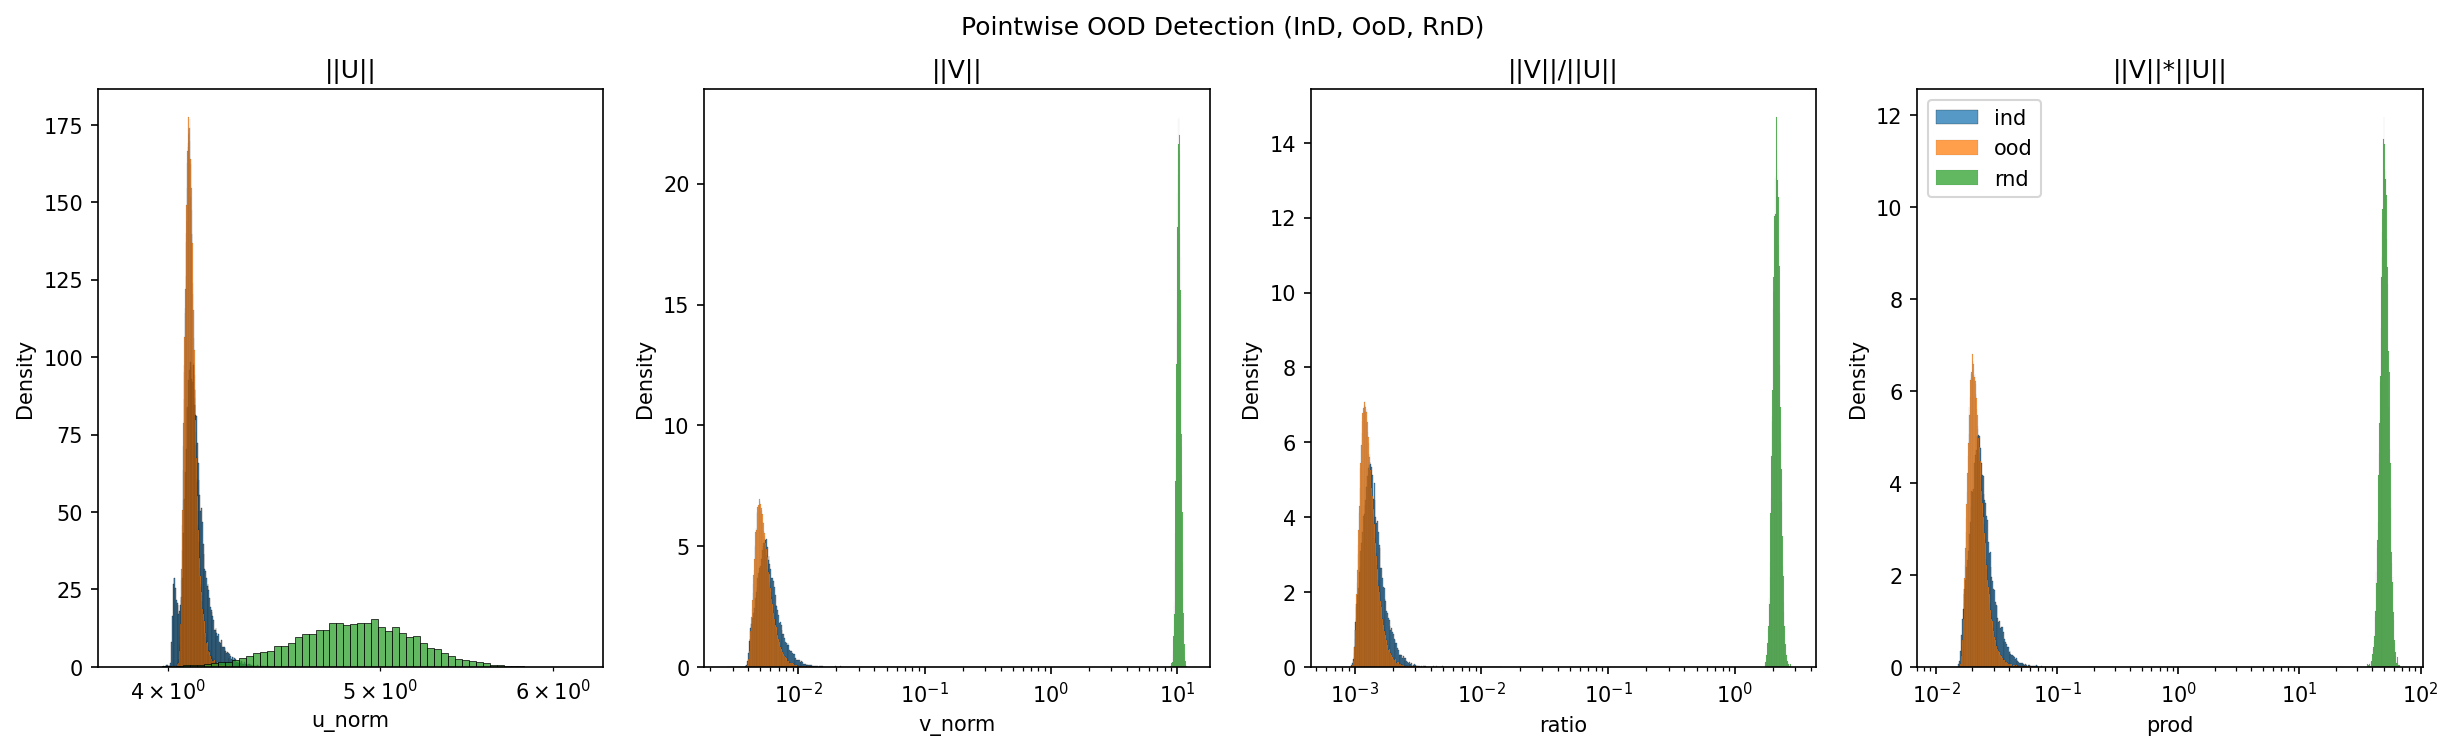

In [12]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

plt.rcParams['figure.figsize'] = (5, 5)
plt.rcParams['figure.dpi'] = 150

data_ind = pd.DataFrame(dict(u_norm=ind_u_norms, v_norm=ind_v_norms, ratio=ind_v_norms/ind_u_norms, prod=ind_v_norms*ind_u_norms, target=ind_targets))
data_ood = pd.DataFrame(dict(u_norm=ood_u_norms, v_norm=ood_v_norms, ratio=ood_v_norms/ood_u_norms, prod=ood_v_norms*ood_u_norms, target=ood_targets))
data_rnd = pd.DataFrame(dict(u_norm=rnd_u_norms, v_norm=rnd_v_norms, ratio=rnd_v_norms/rnd_u_norms, prod=rnd_v_norms*rnd_u_norms))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (20, 5))
fig.suptitle("Pointwise OOD Detection (InD, OoD, RnD)")

sns.histplot(data=data_ind, x="u_norm", log_scale=True, fill=True, label='ind', stat='density', ax=ax1)
sns.histplot(data=data_ood, x="u_norm", log_scale=True, fill=True, label='ood', stat='density', ax=ax1)
sns.histplot(data=data_rnd, x="u_norm", log_scale=True, fill=True, label='rnd', stat='density', ax=ax1)

sns.histplot(data=data_ind, x="v_norm", log_scale=True, fill=True, label='ind', stat='density', ax=ax2)
sns.histplot(data=data_ood, x="v_norm", log_scale=True, fill=True, label='ood', stat='density', ax=ax2)
sns.histplot(data=data_rnd, x="v_norm", log_scale=True, fill=True, label='rnd', stat='density', ax=ax2)

sns.histplot(data=data_ind, x="ratio", log_scale=True, fill=True, label='ind', stat='density', ax=ax3)
sns.histplot(data=data_ood, x="ratio", log_scale=True, fill=True, label='ood', stat='density', ax=ax3)
sns.histplot(data=data_rnd, x="ratio", log_scale=True, fill=True, label='rnd', stat='density', ax=ax3)

sns.histplot(data=data_ind, x="prod", log_scale=True, fill=True, label='ind', stat='density', ax=ax4)
sns.histplot(data=data_ood, x="prod", log_scale=True, fill=True, label='ood', stat='density', ax=ax4)
sns.histplot(data=data_rnd, x="prod", log_scale=True, fill=True, label='rnd', stat='density', ax=ax4)

ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.legend()
plt.show()

In [13]:
from scipy import stats
print("Ind", ind_v_norms.min(), ind_v_norms.max(), ind_v_norms.ptp())
print("Ood", ood_v_norms.min(), ood_v_norms.max(), ood_v_norms.ptp())
print("Rnd", rnd_v_norms.min(), rnd_v_norms.max(), rnd_v_norms.ptp())

ks_ind_ood = stats.kstest(ind_v_norms, ood_v_norms)
print(ks_ind_ood)

Ind 0.0027211218 0.064717494 0.06199637
Ood 0.0027211218 0.35723323 0.3545121
Rnd 8.669412 11.960997 3.291585
KstestResult(statistic=0.19580640778177572, pvalue=0.0, statistic_location=0.0054295203, statistic_sign=-1)


[0 1 3 2 4]


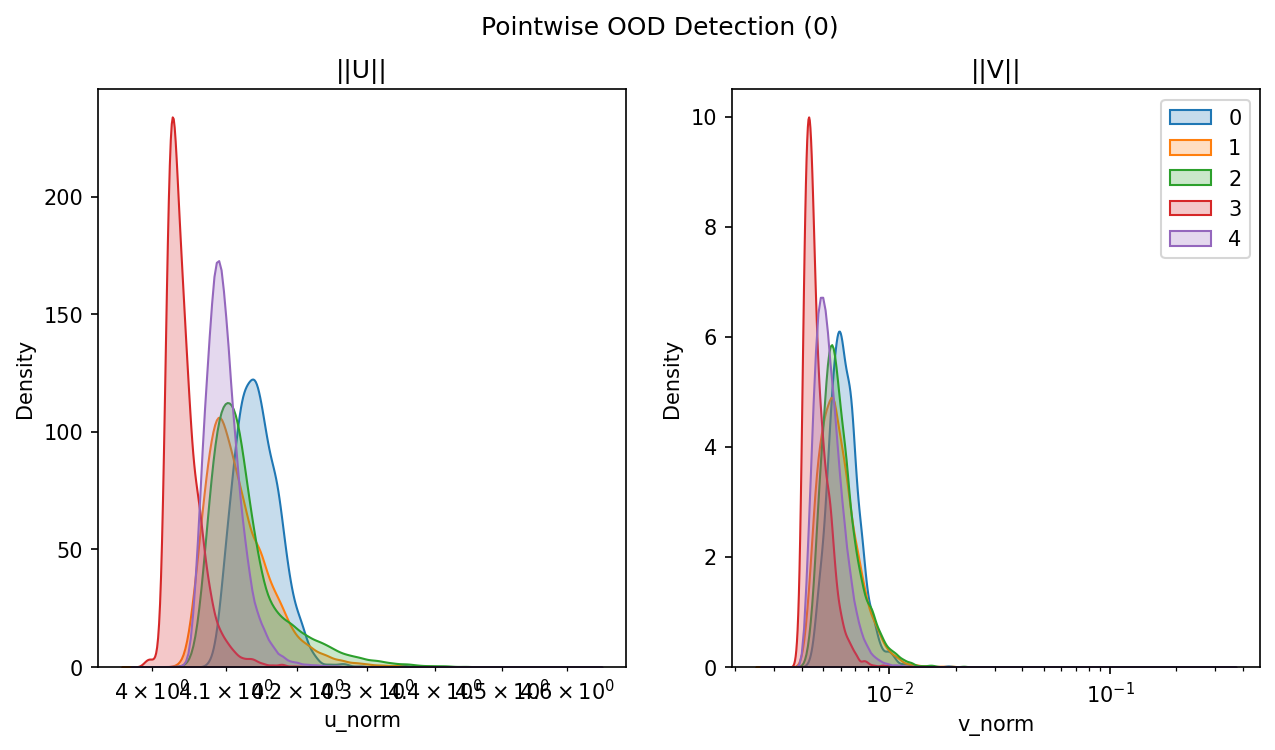

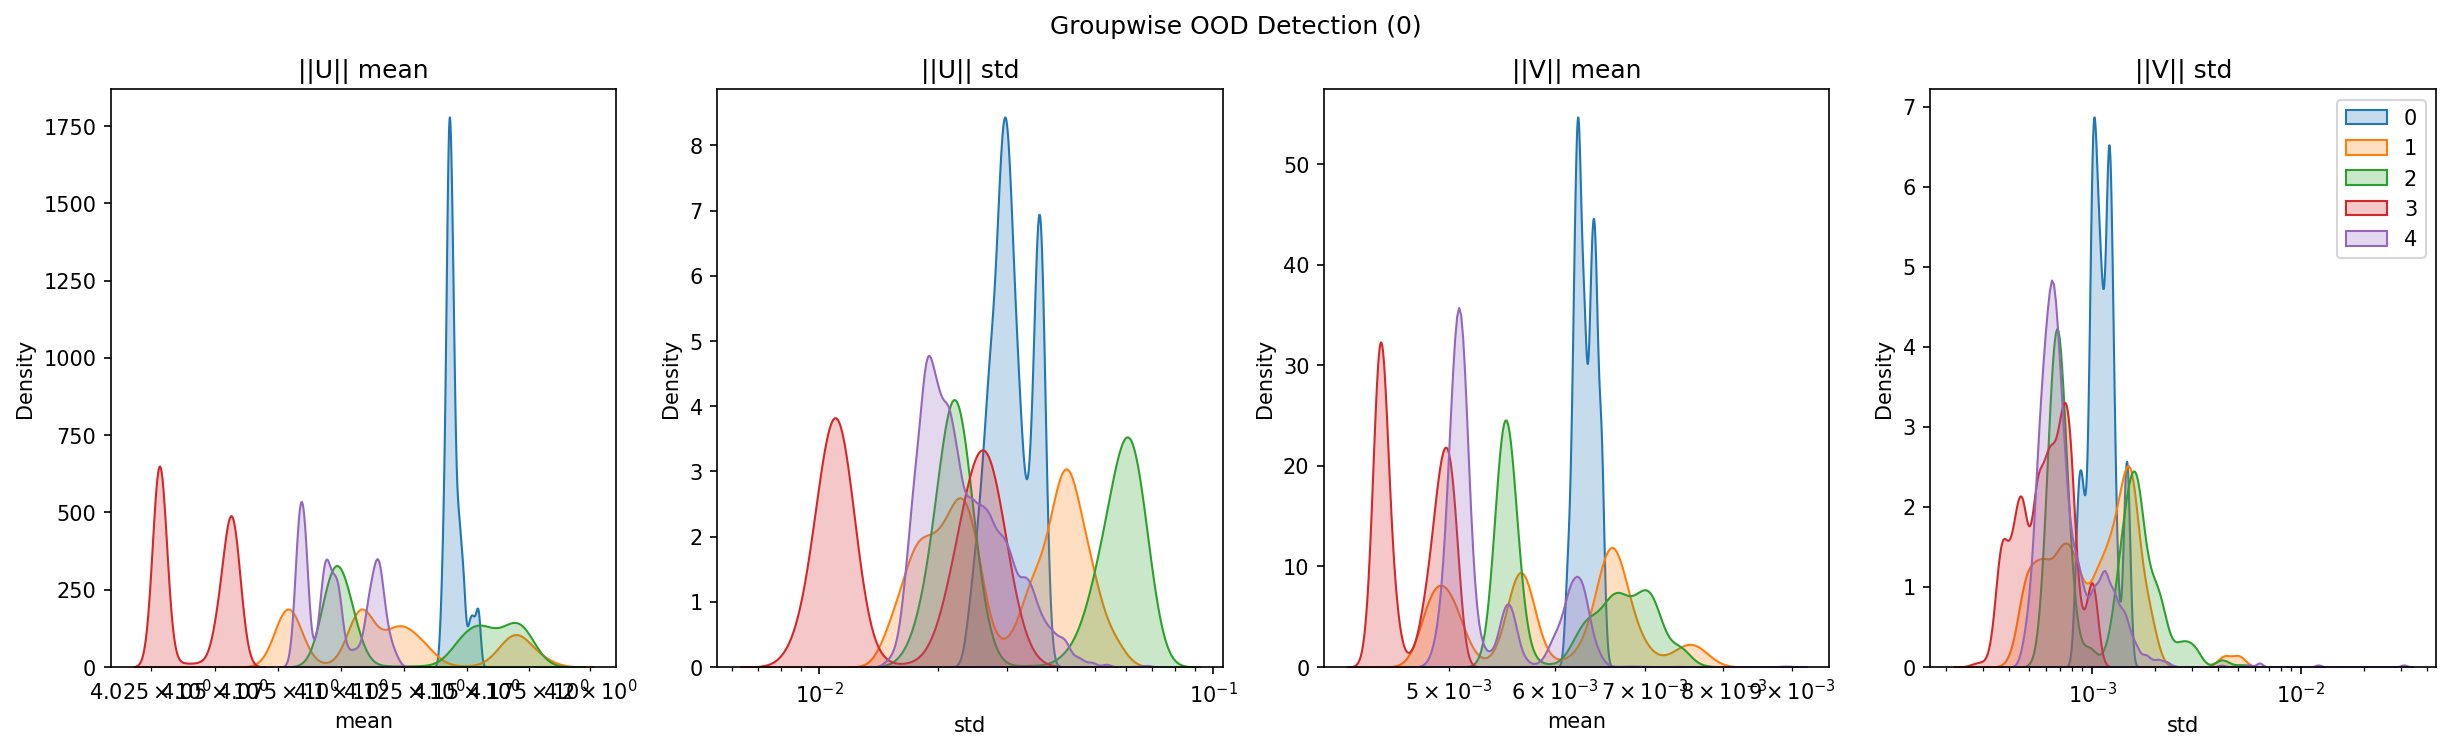

In [14]:
df = pd.concat([data_ind, data_ood], axis=0)
print(df['target'].unique())

N = 128

pointwise = {}
groupwise = {}

for i in range(5):
    df_slice = df[df['target'] == i]
    pointwise[i] = df_slice.copy()
    d = df_slice.rolling(N).agg(['mean', 'std']).dropna()
    groupwise[i] = d.copy()

# pointwise
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
fig.suptitle(f"Pointwise OOD Detection ({':'.join(map(str,config.ood))})")

for i in range(5):
    data = pointwise[i]
    i = str(i)
    sns.kdeplot(data=data, x="u_norm", log_scale=True, fill=True, label=i, ax=ax1)
    sns.kdeplot(data=data, x="v_norm", log_scale=True, fill=True, label=i, ax=ax2)

ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
plt.legend()
plt.show()

    
# groupwise
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (20, 5))
fig.suptitle(f"Groupwise OOD Detection ({':'.join(map(str,config.ood))})")

for i in range(5):
    data = groupwise[i]
    i = str(i)
    sns.kdeplot(data=data.u_norm, x="mean", log_scale=True, fill=True, label=i, ax=ax1)
    sns.kdeplot(data=data.u_norm, x="std", log_scale=True, fill=True, label=i, ax=ax2)
    sns.kdeplot(data=data.v_norm, x="mean", log_scale=True, fill=True, label=i, ax=ax3)
    sns.kdeplot(data=data.v_norm, x="std", log_scale=True, fill=True, label=i, ax=ax4)

ax1.title.set_text('||U|| mean')
ax2.title.set_text('||U|| std')
ax3.title.set_text('||V|| mean')
ax4.title.set_text('||V|| std')
plt.legend()
plt.show()